```
QiskitRuntimeService.save_account(token = <MYTOKEN>,
                                  instance = "open-instance", overwrite = True)
```

In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()

# Create and run a simple quantum program

## Step1: Map the problem to a quantum-native format

In [2]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

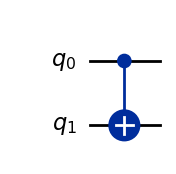

In [4]:
qc = QuantumCircuit(2)

# qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl").
# These guides are written by using Jupyter notebooks, which
# display the output of the last line of each cell.
# If you're running this in a script, use `print(qc.draw())` to
# print a text drawing.
qc.draw("mpl")

In [21]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

## Step2: Optimize the circuits and operators  
When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth. Additionally, circuit's instructions must conform to a backend devices' **Instruction Set Architecture (ISA)** and must consider the devices' basis gates and qubit connectivity  

The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA. It requires that you have already saved your credentials

Selected backend: ibm_fez


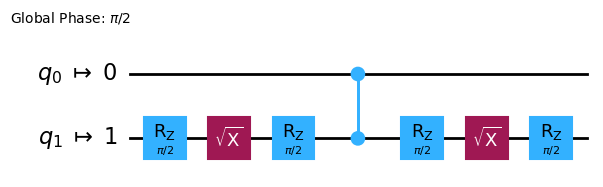

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
print(f"Selected backend: {backend.name}")

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False)

## Step3: Execute using the quantum primitives  
QC can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimates the value of the observables by using ```Estimator``` class. ```Estimator``` is one of two primitives; the other is ```Sampler```, which can be used to get data from a quantum computer. These objects possess a ```run()``` method that executes the selection of circuits, obervables, and parameters, using a **primitive unified bloc (PUB**)

In [ ]:
# Construct the Estimator instance.
 
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) For observable in observables
]
 
# # One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# # Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d48kh4d5mhvc73f927ng


In [24]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

When you run your quantum program on a real device, your workload must wait in a queue before it runs. To save time, you can instead use the following code to run this small workload on the ```fake_provider``` with the Qiskit Runtime local testing mode. Note that this is only possible for a small circuit. When you scale up in the next section, you will need to use a real device

In [26]:
# Use the following code instead if you want to run on a simulator: 
from qiskit_ibm_runtime.fake_provider import FakeFez
backend = FakeFez()
estimator = Estimator(backend)
 
# Convert to an ISA circuit and layout-mapped observables.
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]
print(pub_result)

BasicProviderError: 'Number of qubits 156 is greater than maximum (24) for "basic_simulator".'

## Step4: Analyze the results  
The analyze step is typically where you might post-process your results using QEM. The expectation values and standard deviations for the observables you specified to Estimator are accessed through the joub results's ```PubResult.data.evs``` and ```PubResult.data.stds``` attributies. To obtain the results from Sampler, use the ```PubResult.data.meas.get_counts()``` function, which will return a ```dict``` of measurements in the form of bitstring as keys and counts as their corresponding values.

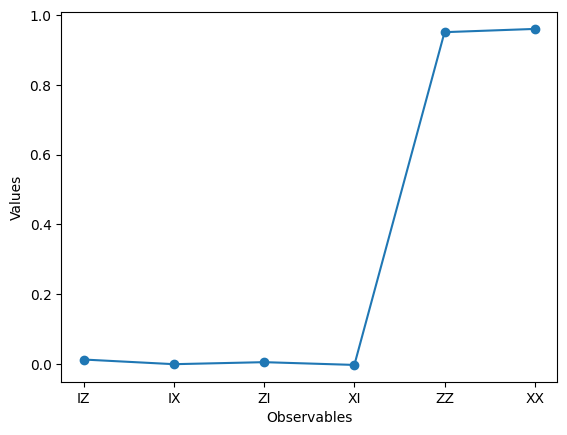

In [25]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

# Scale to large numbers of qubits  
In QC, utility-scale work is crucial for making progress in this field. Such work requires computations to be done on a much larget scale; working with circuits taht might use over 100 qubits and voer 1000 gates. This example demonstrates how you can accomplish utility-scale work on IBM QPUs by creating and analyzing a 100-qubit GHZ state. It uses the Qiskit patterns workflow and ends by measuring the expectation value $ \langle Z_0 Z_i \rangle%$ for each qubit

## Step 1: Map the problem

In [29]:
from qiskit import QuantumCircuit

def get_qc_for_GHZ(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        n (int): Number of qubits in the n-qubit GHZ state
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    qc = QuantumCircuit(n)
    

    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for q in range(1, n):
            qc.cx(0, q)
    else:
        raise Exception("Number of qubits must be an integer >= 2")
    
    return qc

n = 100
qc = get_qc_for_GHZ(n)

Next, map to the operators of interest. This example uses the ```ZZ``` operators b/w qubits to examine the behavior as they get farter apart. Increasingly inaccurate (corrupted) expectation values b/w distant qubits would reveal the level of noise present.

In [32]:
from qiskit.quantum_info import SparsePauliOp
## ZZII...II, ZIZI..II.., ZIIII..IIZ  etc

operator_string = ["Z"+"I" * i + "Z" + "I" * (n-2-i) for i in range(n-1)]
print(operator_string)
print(len(operator_string))

operators = [SparsePauliOp(label) for label in operator_string]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 2: Optimize the problem for execution on quantum hardware  
Ths following code transforms the circuit and observable to match the backend's ISA.

In [33]:
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True, min_num_qubits = n)
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

isa_circuit = pm.run(qc)
isa_operator_list = [op.apply_layout(isa_circuit.layout) for op in operators]

# Step 3: Exxecute on hardware  
Submit the job and enable error suppression by using a technique to reduce errors called dynamical decoupling. Ths resilience level specifies how much resilience to build against errors. Higher levels generate more accurate results, at the expense of longer processing times.

In [36]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(mode=backend, options=options)

In [37]:
job = estimator.run([(isa_circuit, isa_operator_list)])
job_id = job.job_id()
print(f">>> Job ID: {job_id}")

>>> Job ID: d48mkna10n3c73ectrog


## Step4: Post-process results  
After the job completes, plot the results and notice that $\langle Z_0 Z_i \rangle$ decreases with increasing $i$, even though in an ideal simulation all $\langle Z_0 Z_i \rangle$ should be 1

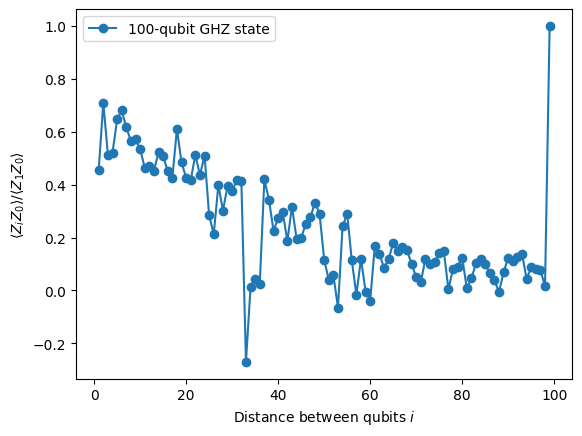

In [49]:
import matplotlib.pyplot as plt
from qiskit_ibm_runtime import QiskitRuntimeService
 
# data
data = list(range(1, len(operators) + 1))  # Distance between the Z operators
result = job.result()[0]
values = result.data.evs  # Expectation value at each Z operator.
values = [
    v / values[0] for v in values
]  # Normalize the expectation values to evaluate how they decay with distance.
 
# plotting graph
plt.plot(data, d, marker="o", label="100-qubit GHZ state") # 맨 마지막이 가장 가까운 큐비트의 기댓값인데 실수로인해 꼬임
plt.xlabel("Distance between qubits $i$")
plt.ylabel(r"$\langle Z_i Z_0 \rangle / \langle Z_1 Z_0 \rangle $")
plt.legend()
plt.show()

In [50]:
result.data.evs

array([ 0.17003771,  0.26413643,  0.19012044,  0.19378404,  0.24079745,
        0.25308366,  0.2293739 ,  0.20983775,  0.21235298,  0.19867253,
        0.17282051,  0.17482697,  0.16824233,  0.19437192,  0.18943249,
        0.16727084,  0.15856976,  0.22699387,  0.17997399,  0.1585501 ,
        0.15522541,  0.19071106,  0.16226972,  0.18958078,  0.1054798 ,
        0.07926438,  0.14831083,  0.11234202,  0.14657119,  0.13943689,
        0.15484535,  0.15394517, -0.10050251,  0.00524693,  0.01596909,
        0.00924262,  0.15604211,  0.12737051,  0.08368093,  0.1022419 ,
        0.10977878,  0.06956522,  0.11796458,  0.07275542,  0.07370913,
        0.09393451,  0.10267599,  0.1234246 ,  0.10769033,  0.04313776,
        0.01496002,  0.02205694, -0.02424868,  0.09005532,  0.10792403,
        0.04223267, -0.0060097 ,  0.04447719, -0.00154999, -0.01414446,
        0.06187729,  0.05186819,  0.03174183,  0.04375523,  0.0668102 ,
        0.05480154,  0.06117556,  0.05653347,  0.03709346,  0.01